<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GP_Unit2_Sprint3_Module3_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW
1. Announcements
2. Gradient Boosting
3. XGBoost
4. Feature Selection
    - GINI Impurity
    - Drop column importances
    - Permutational importances
5. Project module overview

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- scikit-learn
- [**xgboost**](https://xgboost.readthedocs.io/en/latest/)

In [ ]:
!pip install category_encoders
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from IPython.display import Image
from IPython.core.display import HTML 

     |████████████████████████████████| 80 kB 3.8 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, parse_dates=['date_recorded'], na_values=[-2e-08, 0]), 
                         pd.read_csv(tv_path)).set_index('date_recorded')

    else:
        df = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', parse_dates=['date_recorded']).set_index('date_recorded')
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df = df.drop(columns=unusable_variance)
    
    
    # Edftract components from date_recorded, then drop the original column
    df['year_recorded'] = df.index.year
    df['month_recorded'] = df.index.month
    df['day_recorded'] = df.index.day

    # Engineer feature: how many years from construction_year to date_recorded
    df['years'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['years'].isnull()
    
    # return the wrangled dataframe
    return df

In [ ]:
DATA_PATH = '../data/'
fm_path = 'train_features.csv'
tv_path = 'train_labels.csv'
df = wrangle(fm_path, tv_path)

In [ ]:
df

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
date_recorded,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-27,50.0,Dmdd,2092.0,DMDD,35.426020,-4.227446,Narmo,NaN,Internal,Bashnet Kati,Manyara,21,1.0,Babati,Bashinet,160.0,True,Water Board,NaN,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2013,2,27,15.0,False
2011-03-17,NaN,Cmsr,NaN,Gove,35.510074,-5.724555,Lukali,NaN,Internal,Lukali,Dodoma,1,6.0,Bahi,Lamaiti,NaN,True,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,False,False,True,True,True,2011,3,17,NaN,True
2011-07-10,NaN,Kkkt,NaN,KKKT,32.499866,-9.081222,Mahakama,NaN,Lake Rukwa,Chawalikozi,Mbeya,12,6.0,Mbozi,Ndalambo,NaN,True,VWC,NaN,False,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,False,False,True,True,True,2011,7,10,NaN,True
2011-04-12,NaN,NaN,NaN,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,NaN,Rufiji,Shuleni,Mbeya,12,7.0,Mbarali,Chimala,NaN,True,VWC,NaN,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,False,False,True,True,True,2011,4,12,NaN,True
2011-04-05,300.0,Ki,1023.0,Ki,37.032690,-6.040787,Kwa Mjowe,NaN,Wami / Ruvu,Ngholong,Morogoro,5,1.0,Kilosa,Chakwale,120.0,True,VWC,NaN,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,False,False,False,False,False,2011,4,5,14.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-03-20,1000.0,Dhv,327.0,DWE,36.367112,-8.774761,Kwa Mbayambaya,NaN,Rufiji,Bwawani,Morogoro,5,4.0,Ulanga,Mtimbira,255.0,True,Water Board,Mtimbira,True,1995.0,gravity,gravity,gravity,wug,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,20,16.0,False
2011-03-10,1000.0,Danida,1743.0,DANID,34.531524,-9.769604,none,NaN,Lake Nyasa,Mlangali Ndani,Iringa,11,5.0,Ludewa,Mlangali,35.0,True,VWC,DANIDA,False,1988.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2011,3,10,23.0,False
2011-03-13,NaN,Omar Ally,-13.0,Omar Ally,38.974416,-5.420823,Kwa Omar Ally,NaN,Pangani,Sokoni,Tanga,4,5.0,Pangani,Pangani Mashariki,1000.0,False,Private operator,NaN,False,2005.0,other,other,other,private operator,commercial,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other,non functional,False,False,False,False,False,2011,3,13,6.0,False


# SPLIT DATA



In [ ]:
target = 'status_group'
X,y = df.drop(columns=target),df[target]

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.20,random_state=42)

# ESTABLISH BASELINE

In [ ]:
y_train.value_counts(normalize=True).max()

0.5425489938182296

# BUILD MODEL

Decision Trees

Random Forests - bootstrapping to create data sets and use a subset of feature for each split : voted decision for classification and an average for regression - BAGGING

BOOSTING - Ensemble learning method where the trees aren't built in parallel.

If I denote my models using fi(x) then you have the boosted model that yould be a weighted average across all the f(x)s.



In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Fit on train, score on val
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                               

In [ ]:
# Tune parameters like learning rate, n_estimators, And the rest are like your RF models.
model_gbm = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    GradientBoostingClassifier(random_state=42)
)

model_gbm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                   

In [ ]:
# XGBOOST - Extreme gradient boosting is nothing but gradient boosting + regularization. It also does parallel computing.

In [ ]:
model_xgb = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state=42,n_jobs=-1)
)

# Fit on train, score on val
model_xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantit...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta

# CHECK METRICS

In [ ]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))

Training Accuracy 0.9999210837827174
Validation Accuracy 0.8035563973063973


In [ ]:
print('Training Accuracy', model_gbm.score(X_train, y_train))
print('Validation Accuracy', model_gbm.score(X_val, y_val))

Training Accuracy 0.7588583453899777
Validation Accuracy 0.7470538720538721


In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.7521504669209522
Validation Accuracy 0.7423190235690236


Decision trees -> Random Forest (Uses the technique of bootstrapping and bagging for prediction) -> Gradient boosting -> XGBoost

## FEATURE SELECTION
### I Gini impurity

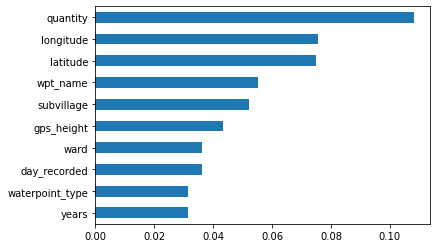

In [ ]:
importances =  model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')

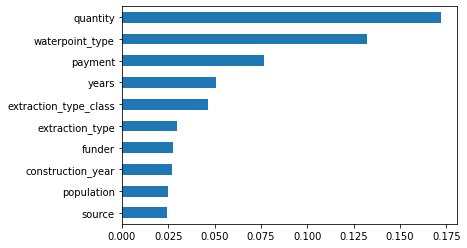

In [ ]:
importances =  model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')

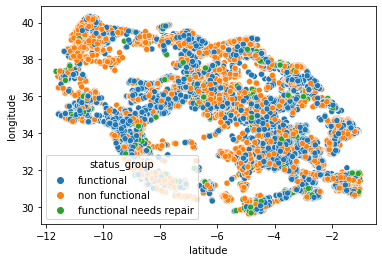

In [ ]:
import seaborn as sns
sns.scatterplot(x='latitude',y='longitude',data=df,hue='status_group')

### II drop column importances

In [ ]:
column = 'source'
# cols = X_train.columns
# for col in cols:
model_dci = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state=42,n_jobs=-1))

model_dci.fit(X_train.drop(columns=column),y_train);

In [ ]:
print('The validation accuracy by dropping quantity is', model_dci.score(X_val.drop(columns=column),y_val))

The validation accuracy by dropping quantity is 0.73989898989899


When we dropped 'quantity', our accuracy dropped from about 74% to 71%. Since it significantly affects our accuracy, we do not drop it.

When we dropped 'payment', the accuracy dropped from 74.2% to about 74%

RFE - Recursive feature elimination

### III Permutation Importance

We train our model first.
Shuffle one column at a time (which is equivalent to corrupting or crating noise) and check if the accuracy drops. If it does, then it means the shuffled column is important and you would retain it in your model.

In [ ]:
Image(url= "https://i.imgur.com/h17tMUU.png")

In [ ]:
model_dci = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    XGBClassifier(random_state=42,n_jobs=-1, n_estimators = 50))

model_dci.fit(X_train,y_train);

In [ ]:
print('The validation accuracy for all features (nestiamtors of 25) is', model_dci.score(X_val,y_val))

The validation accuracy for all features (nestiamtors of 25) is 0.7324284511784511


In [ ]:
X_val_perm = X_val.copy()
X_val_perm['latitude'] = np.random.permutation(X_val_perm['latitude'])

In [ ]:
print('The validation accuracy by shuffling the quantity column is', model_dci.score(X_val_perm,y_val))

The validation accuracy by shuffling the quantity column is 0.7324284511784511


In [ ]:
# Using sklearn permutation_importance library
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(model_dci,X_val,y_val,random_state=42)

In [ ]:
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data,index=X_val.columns).sort_values(by='imp_mean')

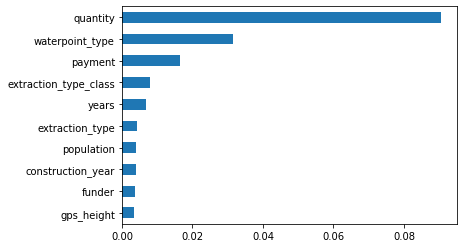

In [ ]:
df_perm['imp_mean'].tail(10).plot(kind='barh')

In [ ]:
df_perm

,imp_mean,imp_std
extraction_type_group,-0.000758,0.000042
source_type,-0.000295,0.000342
month_recorded,-0.000189,0.000079
latitude,-0.000147,0.000434
public_meeting,-0.000063,0.000107
amount_tsh,-0.000042,0.000279
source_class,-0.000021,0.000215
wpt_name,0.000000,0.000000
year_recorded,0.000000,0.000000
population_MISSING,0.000000,0.000000


##  Use xgboost for **gradient boosting**

In [ ]:
Image(url= "https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG")
## The below diagram explains how gradient boosted trees are trained for regression problems.